In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
# Ajouter le dossier src au chemin d'importation
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [3]:
from environments.base_env import HomeostaticEnvironment
from environments.anticipatory_env import AnticipatoryEnvironment
from models.qlearning import QLearning
import numpy as np
import tqdm
import torch
import matplotlib.pyplot as plt

# Experience Anticipation avec QLearning 

In [4]:
# Remarques pour les slides
# 
# Le discount factor est important dans ce cas car avec un discount factor (moins de 0.8) 
# Figure 3C est douteuse car Qlearning ne permet pas de voir un une augmentation lineaire des probabilité de choisir la bonne action
# Que cela soit en softmax ou en epsilon greedy

# Figure 3E douteuse aussi car même remarque sur la figure 3C

In [5]:
# Paramètres

state_size = None  # Nombre d'états possibles mais pas nécéssaire car Q_table custom
action_size = None # Nombre d'actions possibles mais les actions possible sont different selon les etats
alpha = 0.2 # Taux d'apprentissage
gamma = 0.96 # Discount factor
epsilon = 0.2 # Facteur d'exploration
max_epoch = 10  # Nombre d'épisodes
nb_agents = 500 # Nombre d'agents

In [6]:
# Creation de l'agent

Q_table = {
    0: np.zeros(2),  # Etat initial avec 2 actions qui sont anticiper et ne pas anticiper
    1: np.zeros(1),  # Etat ou l'agent a anticipé
    2: np.zeros(1),  # Etat ou l'agent n'a pas anticipé
    3: np.zeros(1),  # Etat terminal
}

Q_table[0][0] = 10 # L'agent ne sait pas anticiper donc au début il devrait choisir de ne pas anticiper

# Instancier le modèle Q-learning
agent = QLearning(state_size=state_size, action_size=action_size, alpha=alpha, gamma=gamma, epsilon=epsilon, q_table=Q_table)


In [7]:
# Définition des paramètres de l'environnement

initial_state = torch.tensor([0.0])  # Température corporelle initiale
setpoints = torch.tensor([0.0])  # Température optimale
weights = torch.tensor([1.0])  # Importance de la température
exponents = [2, 4]  # Non-linéarité / Parametres de drive
effects = {
    # Pas d'effet sur la température de maniere flat, donc gestion dans specifique l'environnment
}
signal_timesteps = [0]
injection_timesteps = [2]
max_timestep = 24 # 30 minutes = 0.5 timestep, ==> 24 heures = 24 timesteps

# Instanciation de l'environnement
env = AnticipatoryEnvironment(
    H=initial_state,
    setpoints=setpoints,
    weights=weights,
    exponents=exponents,
    effects=effects,
    signal_timesteps=signal_timesteps,
    injection_timesteps=injection_timesteps,
    max_timestep=max_timestep
)


In [8]:
# Boucle Q-learning pour apprendre 500 agents
# Liste des agents

agents = []

for i in range(nb_agents):
    agent = QLearning(state_size=state_size, action_size=action_size, alpha=alpha, gamma=gamma, epsilon=epsilon, q_table=Q_table)
    agents.append(agent)

# Etat temporel des Q-tables de chaque agent sur chaque epoch
q_table_state = [[] for _ in range(max_epoch)]
q_table_state[0] = [agent.q_table[0].copy() for agent in agents] # Etat initial

# Etat interne des agents pour chaque epoch
internal_states = [[[] for _ in range(nb_agents)] for _ in range(max_epoch + 2)] # +2 pour inclure l'extinction trial E1 et R1

env.reset()


for epoch in tqdm.tqdm(range(max_epoch), leave=True, position=0, desc="Epoch"):
    anticipate_nb = 0
    not_anticipate_nb = 0
    for i, agent in enumerate(agents):
        internal_state, markov_state, current_timestep = env.reset()
        done = False
        total_reward = 0
        while not done:
            action = agent.choose_action(markov_state)
            internal_state, reward, done, next_markov_state, current_timestep  = env.step(action)
            agent.update_q_value(markov_state, action, reward, next_markov_state)
            markov_state = next_markov_state
            total_reward += reward
            if 0.5 < current_timestep <= 3.0: # timestep_important = [1.0, 1.5, 2.0, 2.5]
                internal_states[epoch][i].append(internal_state)
            if current_timestep == 0.5:
                if action == 0:
                    not_anticipate_nb += 1
                else:
                    anticipate_nb += 1
        q_table_state[epoch].append(agent.q_table[0].copy())
    print(f"Epoch {epoch} : {anticipate_nb} anticipate, {not_anticipate_nb} not anticipate")


Epoch:  10%|█         | 1/10 [00:02<00:19,  2.18s/it]

Epoch 0 : 53 anticipate, 447 not anticipate


Epoch:  20%|██        | 2/10 [00:03<00:15,  1.97s/it]

Epoch 1 : 49 anticipate, 451 not anticipate


Epoch:  30%|███       | 3/10 [00:06<00:15,  2.15s/it]

Epoch 2 : 52 anticipate, 448 not anticipate


Epoch:  40%|████      | 4/10 [00:08<00:12,  2.03s/it]

Epoch 3 : 58 anticipate, 442 not anticipate


Epoch:  50%|█████     | 5/10 [00:10<00:09,  2.00s/it]

Epoch 4 : 47 anticipate, 453 not anticipate


Epoch:  60%|██████    | 6/10 [00:12<00:08,  2.04s/it]

Epoch 5 : 281 anticipate, 219 not anticipate


Epoch:  70%|███████   | 7/10 [00:14<00:06,  2.07s/it]

Epoch 6 : 407 anticipate, 93 not anticipate


Epoch:  80%|████████  | 8/10 [00:16<00:04,  2.11s/it]

Epoch 7 : 441 anticipate, 59 not anticipate


Epoch:  90%|█████████ | 9/10 [00:18<00:02,  2.09s/it]

Epoch 8 : 141 anticipate, 359 not anticipate


Epoch: 100%|██████████| 10/10 [00:20<00:00,  2.09s/it]

Epoch 9 : 418 anticipate, 82 not anticipate


In [9]:
# Extinction trial

extenction_epoch = max_epoch

total_reward = 0
for i, agent in enumerate(agents):
    internal_state, markov_state, current_timestep = env.reset()
    done = False
    total_reward_agent = 0
    while not done:
        action = agent.choose_action(markov_state)
        internal_state, reward, done, next_markov_state, current_timestep  = env.step(action, extinction_trial=True)
        agent.update_q_value(markov_state, action, reward, next_markov_state)
        markov_state = next_markov_state
        total_reward_agent += reward
        if 0.5 < current_timestep <= 3.0: # timestep_important = [1.0, 1.5, 2.0, 2.5]
            internal_states[extenction_epoch][i].append(internal_state)
    total_reward += total_reward_agent

avg_reward = total_reward / nb_agents

print("Extiction trial epoch avg total reward: ", avg_reward)

Extiction trial epoch avg total reward:  tensor(-22.5864)


In [10]:
# Non extinction trial

R1_epoch = max_epoch + 1
total_reward = 0
for i, agent in enumerate(agents):
    internal_state, markov_state, current_timestep = env.reset()
    done = False
    total_reward_agent = 0
    while not done:
        action = agent.choose_action(markov_state)
        internal_state, reward, done, next_markov_state, current_timestep  = env.step(action)
        agent.update_q_value(markov_state, action, reward, next_markov_state)
        markov_state = next_markov_state
        total_reward_agent += reward
        if current_timestep < 2.5: # timestep_important = [0.5, 1.0, 1.5, 2.0]
            internal_states[R1_epoch][i].append(internal_state)
    total_reward += total_reward_agent

avg_reward = total_reward / nb_agents

print("R1 epoch avg total reward: ", avg_reward)

R1 epoch avg total reward:  tensor(-20.0995)


In [11]:
avg_internal_state = [[0, 0, 0, 0] for _ in range(max_epoch + 2)]
for i in range(max_epoch + 2):
    for j in range(nb_agents):
        avg_internal_state[i][0] += internal_states[i][j][0]
        avg_internal_state[i][1] += internal_states[i][j][1]
        avg_internal_state[i][2] += internal_states[i][j][2]
        avg_internal_state[i][3] += internal_states[i][j][3]
    avg_internal_state[i][0] /= nb_agents
    avg_internal_state[i][1] /= nb_agents
    avg_internal_state[i][2] /= nb_agents
    avg_internal_state[i][3] /= nb_agents



xdd 4


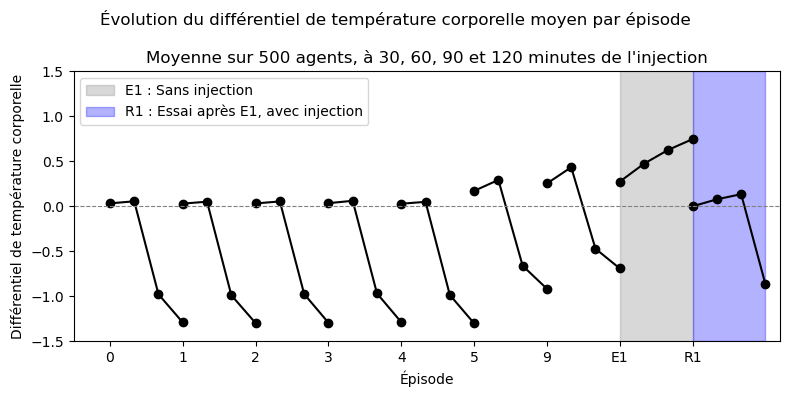

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Exemple de données simulées
blocks = [0, 1, 2, 3, 4, 5, (max_epoch - 1), 'E1', 'R1']  # Les blocs

# Création de la figure
fig, ax = plt.subplots(figsize=(8, 4))

# Ajout des segments pour chaque bloc
for i, block in enumerate(blocks):
    if block == 'E1':
        x = np.linspace(i + 1, i + 2, len(avg_internal_state[extenction_epoch]))  # Espacement sur l'axe X pour chaque bloc
        y = avg_internal_state[extenction_epoch]  # Données pour chaque bloc
    elif block == 'R1':
        x = np.linspace(i + 1, i + 2, len(avg_internal_state[R1_epoch]))
        print(f"xdd {len(avg_internal_state[R1_epoch])}")
        y = avg_internal_state[R1_epoch]
    else:
        x = np.linspace(i + 1, i + 2, len(avg_internal_state[block]))  # Espacement sur l'axe X pour chaque bloc
        y = avg_internal_state[block]  # Données pour chaque bloc
    ax.plot(x, y, 'o-', color='black')  # Trace chaque segment

# Ajout d'une zone ombrée pour E1
ax.axvspan(8, 9, color='gray', alpha=0.3, label="E1 : Sans injection")
ax.axvspan(9, 10, color='blue', alpha=0.3, label="R1 : Essai après E1, avec injection")

# Personnalisation de l'axe X
ax.set_xticks(range(1, len(blocks) + 1))
ax.set_xticklabels(blocks)

# Lignes de base
ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)

# Ajustement des limites
ax.set_ylim(-1.5, 1.5)
ax.set_xlim(0.5, len(blocks) + 1.2)

# Légendes et titre
fig.suptitle("Évolution du différentiel de température corporelle moyen par épisode")
ax.set_title(f"Moyenne sur {nb_agents} agents, à 30, 60, 90 et 120 minutes de l'injection")
ax.set_xlabel("Épisode")
ax.set_ylabel("Différentiel de température corporelle")
ax.legend(loc='upper left')

# Affichage
plt.tight_layout()
plt.savefig("../figs/anticipate/anticipate_temp_evo.png")
plt.show()


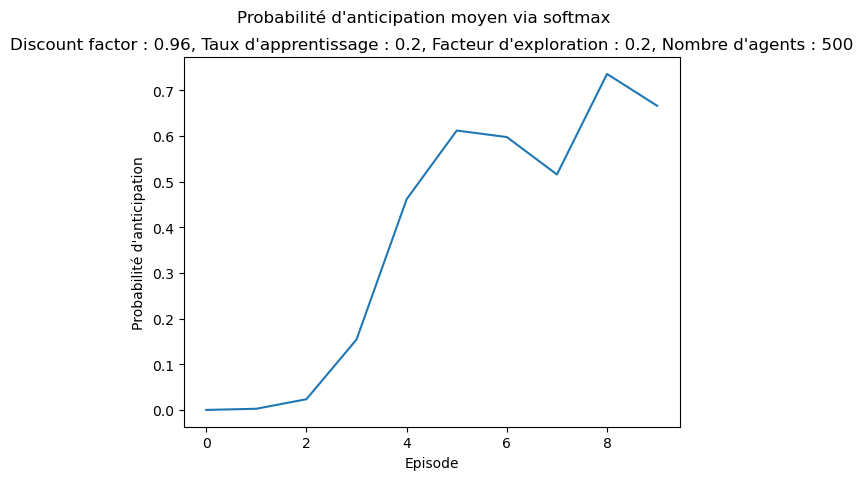

In [41]:
# Evolution des probabilités de choisir une action anticipée

anticipates = []
for epoch, q_values in enumerate(q_table_state):
    max_q_values = np.max(q_values, axis=1, keepdims=True)
    stabilized_q_values = q_values - max_q_values
    exp_q_values = np.exp(stabilized_q_values)
    probas = exp_q_values / np.sum(exp_q_values, axis=1, keepdims=True)
    anticipates.append(probas.mean(axis=0)[1])

plt.plot(anticipates, label="Probabilité d'anticipation")
plt.suptitle("Probabilité d'anticipation moyen via softmax")
plt.title(f"Discount factor : {gamma}, Taux d'apprentissage : {alpha}, Facteur d'exploration : {epsilon}, Nombre d'agents : {nb_agents}")
plt.xlabel("Episode")
plt.ylabel("Probabilité d'anticipation")
plt.savefig(f"../figs/anticipate/anticipate_proba_softmax.pdf")
plt.show()


epoch 0 : 0 / 500
epoch 1 : 0 / 500
epoch 2 : 0 / 500
epoch 3 : 0 / 500
epoch 7 : 134 / 500


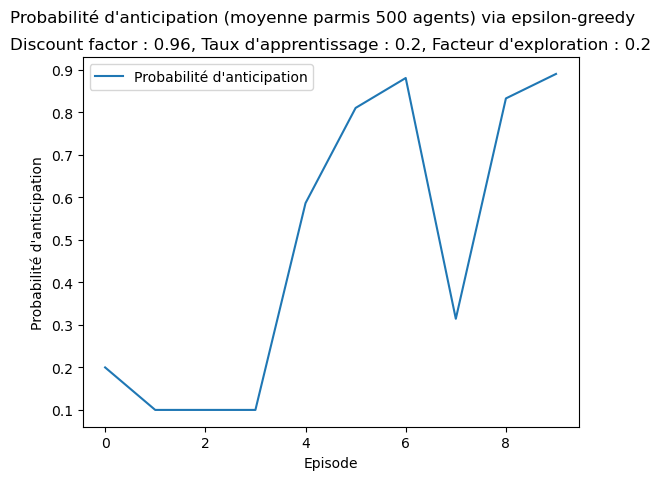

[0, 0, 0, 0, 1, 1, 1, 0, 1, 1]


In [42]:
# Evolution des probabilités de choisir une action anticipée

predominant_choice = []
anticipates = []
for epoch, q_values in enumerate(q_table_state):
    # epsilon greedy
    P = 0
    y = 0
    for i in range(len(q_values)):
        # Si classe dominante
        if np.argmax(q_values[i]) == 1:
            P += (1 - epsilon/2)
            y += 1
        else:
            P += epsilon/2
    anticipates.append(P / nb_agents)
    if y > nb_agents / 2:
        predominant_choice.append(1)
    else:
        predominant_choice.append(0)
        print(f"epoch {epoch} : {y} / {nb_agents}")

plt.plot(anticipates, label="Probabilité d'anticipation")
plt.suptitle("Probabilité d'anticipation (moyenne parmis 500 agents) via epsilon-greedy")
plt.title(f"Discount factor : {gamma}, Taux d'apprentissage : {alpha}, Facteur d'exploration : {epsilon}")
plt.xlabel("Episode")
plt.ylabel("Probabilité d'anticipation")
plt.legend()
plt.savefig("../figs/anticipate/anticipate_proba_egreedy.pdf")
plt.show()

print(predominant_choice)
